<a href="https://colab.research.google.com/github/patrickbryant1/Cfold/blob/master/Cfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cfold
**Structure prediction of alternative protein conformations**


This Colab contains a pipeline for predicting alternative conformations of protein structures. \
\
The network, Cfold, is a structure prediction network similar to AlphaFold2 that is trained on a conformational split of the PDB.
This has the effect of learning to relate one conformation with one MSA representation. \
\
AlphaFold2 is available under the [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0) and so is Cfold, which is a derivative thereof. The Cfold parameters are made available under the terms of the [CC BY 4.0 license](https://creativecommons.org/licenses/by/4.0/legalcode).
\
\
**You may not use these files except in compliance with the licenses.**

Cfold is available for local installation here: https://github.com/patrickbryant1/Cfold

In [ ]:
#@title Install dependencies

#@markdown Make sure your runtime is GPU.
#@markdown In the menu above do: Runtime --> Change runtime type --> Hardware accelerator (set to GPU)

#@markdown **Press play.**

#@markdown You will have to restart the runtime after this finishes to include the new packages.
#@markdown In the menu above do: Runtime --> Restart runtime

#@markdown **After restarting** - reconnect to Google drive.

#@markdown This installation is only required the first time this notebook is run.
!pip install -U jaxlib==0.3.24+cuda11.cudnn82 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install jax==0.3.24
!pip install ml-collections==0.1.1
!pip install dm-haiku==0.0.9
!pip install pandas==1.3.5
!pip install biopython==1.81
!pip install chex==0.1.5
!pip install dm-tree==0.1.8
!pip install immutabledict==2.0.0
!pip install numpy==1.21.6
!pip install scipy==1.7.3
!pip install tensorflow-cpu==2.12.0
!pip install tensorflow==2.11.0
!pip install optax==0.1.4
!pip install py3Dmol

In [ ]:
#@title Clone the Cfold github repo
import shutil
try:
  shutil.rmtree('/content/Cfold', ignore_errors=True)
except:
  print('')

!git clone https://github.com/patrickbryant1/Cfold.git

In [ ]:
#@title #Follow all steps outlined below to run Cfold
#@markdown To try the **test case** 4AVA, click the box "test_case". Then press the play button to the left.
\
#@markdown If you don't want to run the test case, **leave the box blank**.

#@markdown #Settings
#@markdown - *ID* - name \
#@markdown - **MSA** - currently no MSA search is available directly in the browser, therefore you have to provide your own MSAs in a3m format and upload them here. \

#@markdown Go to https://toolkit.tuebingen.mpg.de/tools/hhblits \
#@markdown Paste your protein sequence in the search field in fasta format --> Submit. \
#@markdown When the search is finished, go to the tab "Query Template MSA" and "Download Full A3M" \
#@markdown Upload the MSAs here: \
#@markdown Click the folder icon (Files) to the left and select the upload file icon. Upload your files.
#@markdown Make sure to name your MSA **"ID".a3m**

#@markdown - NUM_RECYCLES - how many recycles to use in the network
#@markdown - NUM_SAMPLES - how many samples to take per cluster size.

import sys, os
from google.colab import files
import pandas as pd
import numpy as np
import glob
sys.path.insert(0,'/content/Cfold/src')
test_case = True #@param {type:"boolean"}
ID = "4AVA" #@param {type:"string"}
NUM_RECYCLES = 3 # @param {type:"integer"}
NUM_SAMPLES = 5 # @param {type:"integer"}
CLUSTERS = "16,32,64,128,256,512,1024" #@param {type:"string"}
SEQUENCE = "DGIAELTGARVEDLAGMDVFQGCPAEGLVSLAASVQPLRAAAGQVLLRQGEPAVSFLLISSGSAEVSHVGDDGVAIIARALPGMIVGEIALLRDSPRSATVTTIEPLTGWTGGRGAFATMVHIPGVGERLLRTARQRLAAFVSPIPVRLADGTQLMLRPVLPGDRERTVHGHIQFSGETLYRRFMSPALMHYLSEVDYVDHFVWVVTDGSDPVADARFVRDETDPTVAEIAFTVADAYQGRGIGSFLIGALSVAARVDGVERFAARMLSDNVPMRTIMDRYGAVWQREDVGVITTMIDVPGPGELSLGREMVDQINRVARQVIEAVG" #@param {type:"string"}
OUTDIR="/content/"+ID+'/'
if not os.path.exists(OUTDIR):
  os.mkdir(OUTDIR)

#Create list of clusters
CLUSTERS=CLUSTERS.split(',')
CLUSTERS = [int(x) for x in CLUSTERS]
#Check that MSA exists
if test_case!=True:
  #Write fasta
  with open('/content/'+ID+'.fasta', 'w') as file:
    file.write('>'+ID+'\n')
    file.write(SEQUENCE)
  #Check that MSA exists
  try:
    with open('/content/'+ID+'.a3m', 'r') as file:
      for line in file:
        if line[0]=='>':
          continue
        else:
          line = line.rstrip()
          if line!=SEQUENCE:
            print('The sequence provided and the sequence in the MSA do not match!')

    MSA='/content/'+ID+'.a3m'
    FASTA_FILE='/content/'+ID+'.fasta'
  except:
    print('No MSA.')
    print('Please provide an MSA named '+ID+'.a3m')
else:
  MSA='/content/Cfold/data/test/'+ID+'.a3m'
  FASTA_FILE='/content/Cfold/data/test/'+ID+'.fasta'


print('Using MSA:',MSA)
print('Using fasta file:',FASTA_FILE)
print('Using',NUM_RECYCLES,'recycles with',NUM_SAMPLES, 'samples per cluster with clusters', CLUSTERS)

#Get the Cfold parameters (if not downloaded)
if not os.path.exists('/content/params10000.npy'):
  print('Getting Cfold network parameters.')
  !wget https://gitlab.com/patrickbryant1/cfold_data/-/raw/main/params10000.npy

In [ ]:
#@title Generate the input features for the network and predict.
#@markdown If the Run is interrupted - don't worry - it will continue where it left off.
#@markdown You may have to rerun this several times to generate all samples, depending on the GPU you have available here in Colab.
from make_msa_seq_feats_colab import process
from predict_with_clusters_colab import predict
import collections
collections.Iterable = collections.abc.Iterable
import pickle

#Feats
features_output_path = os.path.join(OUTDIR, 'msa_features.pkl')

if not os.path.exists(features_output_path):
  #Get feats
  feature_dict = process(FASTA_FILE, [MSA])

  #Write out features as a pickled dictionary.

  with open(features_output_path, 'wb') as f:
      pickle.dump(feature_dict, f, protocol=4)
  print('Saved features to',features_output_path)
else:
  print('Features exist at',features_output_path)

try:
  ckpt_params = np.load('/content/params10000.npy' , allow_pickle=True)
except:
  print('Could not load params. Try deleting them and rerun the step above.')
#Predict
predict('/content/', ID, NUM_RECYCLES, NUM_SAMPLES, CLUSTERS, ckpt_params, OUTDIR)

In [ ]:
#@title Download results
from google.colab import files
import glob
print('All files are available in', OUTDIR)
for name in glob.glob(OUTDIR+'*.pdb'):
  files.download(name)

In [ ]:
#@title Align the predicted alternative conformations for visualisation.
from score_closest_ca_colab import read_pdb, score_ca_diff, align_coords_transform, write_pdb
if not os.path.exists(OUTDIR+'/roto_transl/'):
  os.mkdir(OUTDIR+'/roto_transl/')
#Score
#Read in all coords
pdb_info = {'name':[], 'file_contents':[], 'all_coords':[], 'ca_coords':[]}
print('Reading preds...')
for name in glob.glob(OUTDIR+'*.pdb'):
    current_info, current_coords, current_ca_coords = read_pdb(name)
    pdb_info['name'].append(name)
    pdb_info['file_contents'].append(current_info)
    pdb_info['all_coords'].append(current_coords)
    pdb_info['ca_coords'].append(current_ca_coords)

#Score all
print('Scoring...')
score_matrix, order = score_ca_diff(pdb_info['ca_coords'])
#Save
np.save(OUTDIR+'/roto_transl/score_mat.npy',score_matrix)
#Align according to order and write to out
#Copy the first one to out
print('Writing aligned structures...')
shutil.copy(pdb_info['name'][order[0]], OUTDIR+'/roto_transl/'+pdb_info['name'][order[0]].split('/')[-1])
tr_current_ca = pdb_info['ca_coords'][order[0]]
ordered_names = [pdb_info['name'][order[0]].split('/')[-1]]
for i in range(1,len(order)):
    #Align i+1 to i
    tr_current_coords, tr_current_ca = align_coords_transform(tr_current_ca, pdb_info['ca_coords'][order[i]], pdb_info['all_coords'][order[i]])
    #Write new pdb file
    write_pdb(pdb_info['file_contents'][order[i]], tr_current_coords, pdb_info['name'][order[i]].split('/')[-1], OUTDIR+'/roto_transl/')
    ordered_names.append(pdb_info['name'][order[i]].split('/')[-1])

#Save order
order_df = pd.DataFrame()
order_df['name'] = ordered_names
order_df.to_csv(OUTDIR+'/roto_transl/aligned_order.csv', index=None)
print('Saved the aligned order to', OUTDIR+'/roto_transl/aligned_order.csv')

In [52]:
#@title Animate
#@markdown - How many frames to animate using NUM_FRAMES structuers selected evenly among all samples.
NUM_FRAMES = 50 # @param {type:"integer"}
COLOR = "spectrum" # @param ["grey", "spectrum"]
STYLE = "cartoon" # @param ["cartoon", "stick", "sphere"]

#Animate
class Atom(dict):
    def __init__(self, line):
        self["type"] = line[0:6].strip()
        self["idx"] = line[6:11].strip()
        self["name"] = line[12:16].strip()
        self["resname"] = line[17:20].strip()
        self["resid"] = int(int(line[22:26]))
        self["x"] = float(line[30:38])
        self["y"] = float(line[38:46])
        self["z"] = float(line[46:54])
        self["sym"] = line[76:78].strip()

    def __str__(self):
        line = list(" " * 80)

        line[0:6] = self["type"].ljust(6)
        line[6:11] = self["idx"].ljust(5)
        line[12:16] = self["name"].ljust(4)
        line[17:20] = self["resname"].ljust(3)
        line[22:26] = str(self["resid"]).ljust(4)
        line[30:38] = str(self["x"]).rjust(8)
        line[38:46] = str(self["y"]).rjust(8)
        line[46:54] = str(self["z"]).rjust(8)
        line[76:78] = self["sym"].rjust(2)
        return "".join(line) + "\n"

class Molecule(list):
    def __init__(self, file):
        for line in file:
            if "ATOM" in line or "HETATM" in line:
                self.append(Atom(line))

    def __str__(self):
        outstr = ""
        for at in self:
            outstr += str(at)

        return outstr

import py3Dmol
import pandas as pd
order_df = pd.read_csv(OUTDIR+'/roto_transl/aligned_order.csv')
molecules = []

if NUM_FRAMES>=len(order_df):
  sel=order_df
else:
  sel = order_df.loc[np.round(np.linspace(1,len(order_df)-1,NUM_FRAMES))]
for ind,row in sel.iterrows():
    with open(OUTDIR+'/roto_transl/'+row['name']) as ifile:
        molecules.append(Molecule(ifile))


view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)

models = ""
for i, mol in enumerate(molecules):
    models += "MODEL " + str(i) + "\n"
    models += str(mol)
    models += "ENDMDL\n"
view.addModelsAsFrames(models)

for i, at in enumerate(molecules[0]):
    default = {STYLE: {'color': COLOR}}
    view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))

print('Animation for', ID)

view.animate({'loop': 'backAndForth'})
view.zoomTo()
view.show()

Animation for 4AVA


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

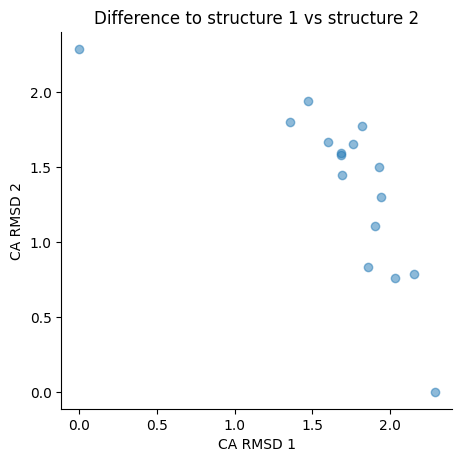

In [68]:
#@title Visualise the biggest structural differences
import numpy as np
import pandas as pd
scores = np.load(OUTDIR+'/roto_transl/score_mat.npy')
scores[scores==1000]=0
max_diff_inds = np.unravel_index(scores.argmax(), scores.shape)
order_df = pd.read_csv(OUTDIR+'/roto_transl/aligned_order.csv')

#Display the max diff structures
model_1=OUTDIR+'/roto_transl/'+order_df.loc[0]['name']
model_2=OUTDIR+'/roto_transl/'+order_df.loc[len(order_df)-1]['name']
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.addModel(open(model_1,'r').read(),'pdb')
view.addModel(open(model_2,'r').read(),'pdb')
view.setStyle({'cartoon': {'color':'spectrum'}})
view.zoomTo()
view.show()

import matplotlib.pyplot as plt
row_1 = scores[max_diff_inds[0],:]
row_2 = scores[max_diff_inds[1],:]
fig, ax = plt.subplots(figsize=(12/2.54, 12/2.54))
plt.scatter(row_1, row_2, alpha=0.5)
plt.xlabel('CA RMSD 1')
plt.ylabel('CA RMSD 2')
plt.title('Difference to structure 1 vs structure 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()